# VQD for H2 molucule

- ScipyOptimizer
- Qiskit algorithm optimizer
- reference  
O. Higgott, D. Wang, and S. Brierley (2019). "Variational quantum computation of excited states." Quantum, 3, 156.


In [1]:
from qiskit_nature.settings import settings

settings.dict_aux_operators = True

In [2]:
import numpy as np
import pylab

from qiskit import Aer
from qiskit import QuantumCircuit, transpile

from qiskit.opflow import I, X, Y, Z, StateFn, CircuitStateFn
from qiskit.opflow.converters import CircuitSampler
from qiskit.opflow.expectations import PauliExpectation, AerPauliExpectation

from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP, POWELL,SPSA

from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.circuit.library import TwoLocal
from qiskit.circuit import QuantumCircuit, ParameterVector

from qiskit_nature.drivers import UnitsType, Molecule                                                                   
from qiskit_nature.drivers.second_quantization import ElectronicStructureDriverType, ElectronicStructureMoleculeDriver  
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem                                       
from qiskit_nature.converters.second_quantization import QubitConverter                                                 
from qiskit_nature.mappers.second_quantization import JordanWignerMapper, ParityMapper                                  
from qiskit.providers.aer import StatevectorSimulator 

from qiskit.circuit.library import EfficientSU2

from qiskit_nature.properties.second_quantization.electronic import (                                                   
    ElectronicEnergy,                                                                                                   
    ElectronicDipoleMoment,                                                                                             
    ParticleNumber,                                                                                                     
    AngularMomentum,                                                                                                    
    Magnetization,                                                                                                      
)                                                                                                                       

import random

## Define H2 molecule

- charge  
0
- multiplicity  
2S+1 = 1
- basis  
sto3g
- two-qubit reduction  
True

In [3]:
charge = 0
multiplicity = 1
geometry = [['H',(0,0,0)],['H',(0.977,0,0)]]
basis = 'sto3g'

molecule = Molecule(geometry=geometry,                                                                     
                    charge=charge,
                    multiplicity=multiplicity)  

# pyscf driver
driver = ElectronicStructureMoleculeDriver(molecule,                                                                                                 
                                           basis=basis,                                                                                           
                                           driver_type=ElectronicStructureDriverType.PYSCF)                                                           
properties = driver.run()                                                                                  
particle_number = properties.get_property(ParticleNumber)                                                       
electronic_energy = properties.get_property(ElectronicEnergy)
nuclear_repulsion_energy = electronic_energy.nuclear_repulsion_energy

# convert qubit hamiltonian
es_problem = ElectronicStructureProblem(driver)        
second_q_op = es_problem.second_q_ops()
#qubit_converter = QubitConverter(mapper=JordanWignerMapper(),two_qubit_reduction=True)
qubit_converter = QubitConverter(mapper=ParityMapper(), two_qubit_reduction=True)
qubit_hamiltonian = qubit_converter.convert(second_q_op["ElectronicEnergy"], num_particles=es_problem.num_particles)

In [4]:
def get_expectation_energy_gs(qubit_hamiltonian,params,ansatz,shots=None):

    qc = QuantumCircuit(2)
    qc.append(ansatz.bind_parameters(params),[0,1])    
    psi = CircuitStateFn(qc)    
    
    # simulator background
    measurable_expression = StateFn(qubit_hamiltonian, is_measurement=True).compose(psi)  
    
    if shots==None:
        backend = Aer.get_backend('statevector_simulator') 
        q_instance = QuantumInstance(backend)
        
        expectation = AerPauliExpectation().convert(measurable_expression)
        sampler = CircuitSampler(q_instance).convert(expectation)     
        energy = sampler.eval().real

    else:
        backend = Aer.get_backend('qasm_simulator',shots=shots) 
        q_instance = QuantumInstance(backend)
        
        expectation = PauliExpectation().convert(measurable_expression)
        sampler = CircuitSampler(q_instance).convert(expectation) 
        energy = sampler.eval().real
    
    return energy

In [5]:
def get_expectation_energy(qubit_hamiltonian,nuclear_repulsion_energy, params,ansatz,shots=None):
    
    qc = QuantumCircuit(2)
    qc.append(ansatz.bind_parameters(params),[0,1])    
    psi = CircuitStateFn(qc)    

    # simulator background
    measurable_expression = StateFn(qubit_hamiltonian, is_measurement=True).compose(psi)
    
    if shots==None:
        backend = Aer.get_backend('statevector_simulator') 
        q_instance = QuantumInstance(backend)
        expectation = AerPauliExpectation().convert(measurable_expression)
        sampler = CircuitSampler(q_instance).convert(expectation)     
        energy = sampler.eval().real
        
    else:
        backend = Aer.get_backend('qasm_simulator',shots=shots) 
        q_instance = QuantumInstance(backend)
        expectation = PauliExpectation().convert(measurable_expression)
        sampler = CircuitSampler(q_instance).convert(expectation) 
        energy = sampler.eval().real
    
    return energy + nuclear_repulsion_energy

In [6]:
# inversion test
# calculate <0| U+(Θ0) U(Θ1) |0>**2

def UU(ansatz,opt_params, params, shots=None):

    qc = QuantumCircuit(2)
    qc.append(ansatz.bind_parameters(params),[0,1]) 
    qc.append(ansatz.bind_parameters(opt_params).inverse(),[0,1])     
      
    backend = Aer.get_backend('statevector_simulator') 
    compiled_circuit = transpile(qc, backend)
    job = backend.run(compiled_circuit)
    result = job.result().data()['statevector']
    return np.abs(result[0])**2
        

## ansatz
- Hardware Efficient ansatz  
Efficient SU2
https://qiskit.org/documentation/stubs/qiskit.circuit.library.EfficientSU2.html

In [7]:
ansatz = EfficientSU2(num_qubits=2,                                                                              
                      reps=2,                                                                                   
                      entanglement='linear',                                                                        
                      insert_barriers=True)   

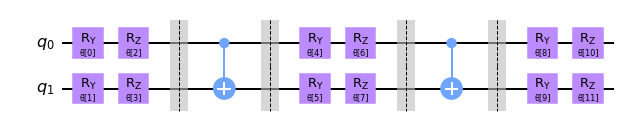

In [8]:
ansatz.decompose().draw('mpl')

## VQE iteration for ground state

In [9]:
import scipy.optimize
import matplotlib.pyplot as plt
from qiskit.algorithms.optimizers import SLSQP, COBYLA, SPSA, NFT, L_BFGS_B, GSLS, CG
from qiskit.algorithms.optimizers import TNC, SNOBFIT, QNSPSA, P_BFGS, NELDER_MEAD
from qiskit.algorithms.optimizers import ADAM, BOBYQA, GradientDescent, IMFIL
from qiskit.algorithms.optimizers import SciPyOptimizer

Nval = 0
N_val = []
cost_val = [] 

converge_cnts = np.empty([], dtype=object)
converge_vals = np.empty([], dtype=object)

params = [random.random() for i in range(ansatz.num_parameters)]

def cost(params):
    return get_expectation_energy_gs(qubit_hamiltonian,params,ansatz,shots=None)

def callback(params,*wargs):
    global cost_val, N_val, Nval
    cost_val.append(cost(params))
    N_val.append(Nval)
    
    if Nval%20==0:
        print('{0:4d}   {1:3.9f}'.format(Nval,cost(params)))
    Nval = Nval + 1

optimizer = L_BFGS_B(maxiter=100, callback=callback)

print('{0:4s}     {1:12s}'.format('  Iter', 'energy'))

result=optimizer.minimize(cost, params)
opt_params = result.x

  Iter     energy      
   0   -1.213240203


(array([-1.7, -1.6, -1.5, -1.4, -1.3, -1.2, -1.1]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

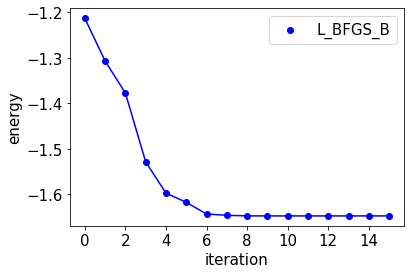

In [10]:
pylab.rcParams['figure.figsize'] = (6, 4)
c=['blue','green','red','pink']
#for i, optimizer in enumerate(optimizers):
pylab.scatter(N_val, np.array(cost_val), label=type(optimizer).__name__,color=c[0])
pylab.plot(N_val, np.array(cost_val), color=c[0])

pylab.xlabel('iteration',fontsize='15')
pylab.ylabel('energy',fontsize='15')
pylab.legend(loc='upper right',fontsize='15')
pylab.xticks(fontsize='15')
pylab.yticks(fontsize='15')
#pylab.hlines(exact,xmin=0,xmax=300, color='red',linestyles='--')

In [11]:
opt_params

array([ 1.71358618, -0.48791541, -0.0107831 ,  1.11661871,  1.37613803,
        1.0440715 ,  0.62499299, -0.21311694,  1.75444015,  0.2078409 ,
        1.26632865,  1.58787336])

In [12]:
#exact (ground state) -1.1059333523046924
get_expectation_energy(qubit_hamiltonian,nuclear_repulsion_energy,opt_params,ansatz,shots=None)

-1.1059333522961754

## Potential Energy Surface

In [13]:
def H(dist):
    # define H2 molecule
    charge = 0
    multiplicity = 1
    geometry = [['H',(0,0,0)],['H',(dist,0,0)]]
    basis = 'sto3g'

    molecule = Molecule(geometry=geometry,                                                                     
                        charge=charge,
                        multiplicity=multiplicity)  

    # pyscf driver
    driver = ElectronicStructureMoleculeDriver(molecule,                                                                                                 
                                               basis=basis,                                                                                           
                                               driver_type=ElectronicStructureDriverType.PYSCF)                                                           
    properties = driver.run()                                                                                  
    particle_number = properties.get_property(ParticleNumber)                                                       
    electronic_energy = properties.get_property(ElectronicEnergy)
    nuclear_repulsion_energy = electronic_energy.nuclear_repulsion_energy

    # convert qubit hamiltonian
    es_problem = ElectronicStructureProblem(driver)
    qubit_converter = QubitConverter(mapper=ParityMapper(), two_qubit_reduction=True)                                                                                                                                                                                  
    second_q_op = es_problem.second_q_ops()                                          
    qubit_hamiltonian = qubit_converter.convert(second_q_op["ElectronicEnergy"], num_particles=es_problem.num_particles)

    return qubit_hamiltonian, nuclear_repulsion_energy

In [14]:
bls=np.arange(0.4,2.4,0.2)

eng0=[]
eng1=[]

for i in range(len(bls)):

    print(i)
    qubit_hamiltonian, nuclear_repulsion_energy = H(bls[i])
    
    # ground state
    def cost0(params):
        return get_expectation_energy_gs(qubit_hamiltonian,params,ansatz,shots=None)

    params0 = [random.random() for i in range(ansatz.num_parameters)]
    optimizer = L_BFGS_B(maxiter=200)
    result=optimizer.minimize(cost, params0)
    opt_params0 = result.x
    
    y0 = get_expectation_energy(qubit_hamiltonian,nuclear_repulsion_energy, opt_params0,ansatz,shots=None)
    eng0.append(y0)
    
    # excited state
    def cost1(params):
        return get_expectation_energy_gs(qubit_hamiltonian,params,ansatz,shots=None) + 1.0 * UU(ansatz,opt_params0, params, shots=None)
    
    params1 = [random.random() for i in range(ansatz.num_parameters)]
    optimizer = L_BFGS_B(maxiter=200)
    result=optimizer.minimize(cost1, params1)
    opt_params1 = result.x
    
    y1 = get_expectation_energy(qubit_hamiltonian,nuclear_repulsion_energy, opt_params1,ansatz,shots=None) + 1.0 * UU(ansatz,opt_params0, opt_params1, shots=None)
    eng1.append(y1)

0
1
2
3
4
5
6
7
8
9


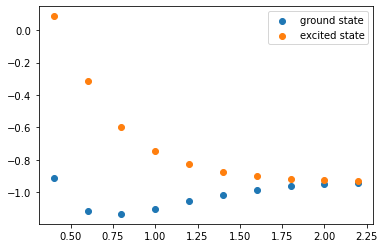

In [15]:
import matplotlib.pyplot as plt
plt.scatter(bls, eng0, label='ground state')
plt.scatter(bls, eng1, label='excited state')
plt.legend()
plt.savefig('test.png')